# **Mounting the Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  **Importing necessary libraries**

In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline

In [4]:
!unzip '/content/drive/MyDrive/Colab Notebooks/histopathologic-cancer-detection.zip' > /dev/null

.

> # Reading the Dataset

In [12]:
labels_df = pd.read_csv('/content/train_labels.csv')
print(labels_df.head().to_markdown())

print("\nShape of the dataset is : ", labels_df.shape)

|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |

Shape of the dataset is :  (220025, 2)


In [13]:
print("Number of Duplicate elements in Dataset is : ",  int((labels_df[labels_data.duplicated(keep=False)]).sum().sum()))

Number of Duplicate elements in Dataset is :  0


In [15]:
imgpath ="/content/train" 

malignant = labels_df.loc[labels_df['label']==1]['id'].values    
normal = labels_df.loc[labels_df['label']==0]['id'].values      

print("Size of Malignant elements in dataset : ", len(malignant))
print("Size of Normal elements in dataset : ", len(normal))

Size of Malignant elements in dataset :  89117
Size of Normal elements in dataset :  130908


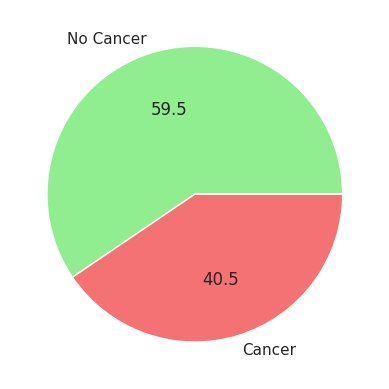

In [ ]:
plt.pie(labels.label.value_counts(), labels=['No Cancer', 'Cancer'], colors=['#90EE91', '#F47174'], autopct='%1.1f')
plt.show()

In [62]:
def plot_img(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(title, y=0.94)

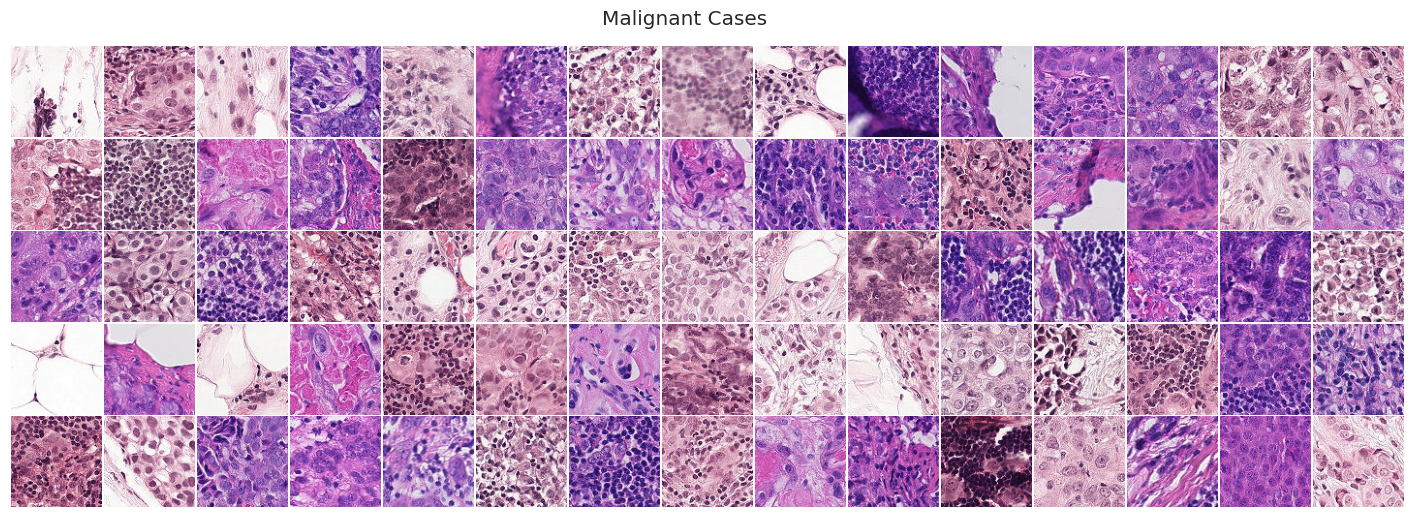

In [63]:
plot_img(malignant,'Malignant Cases')

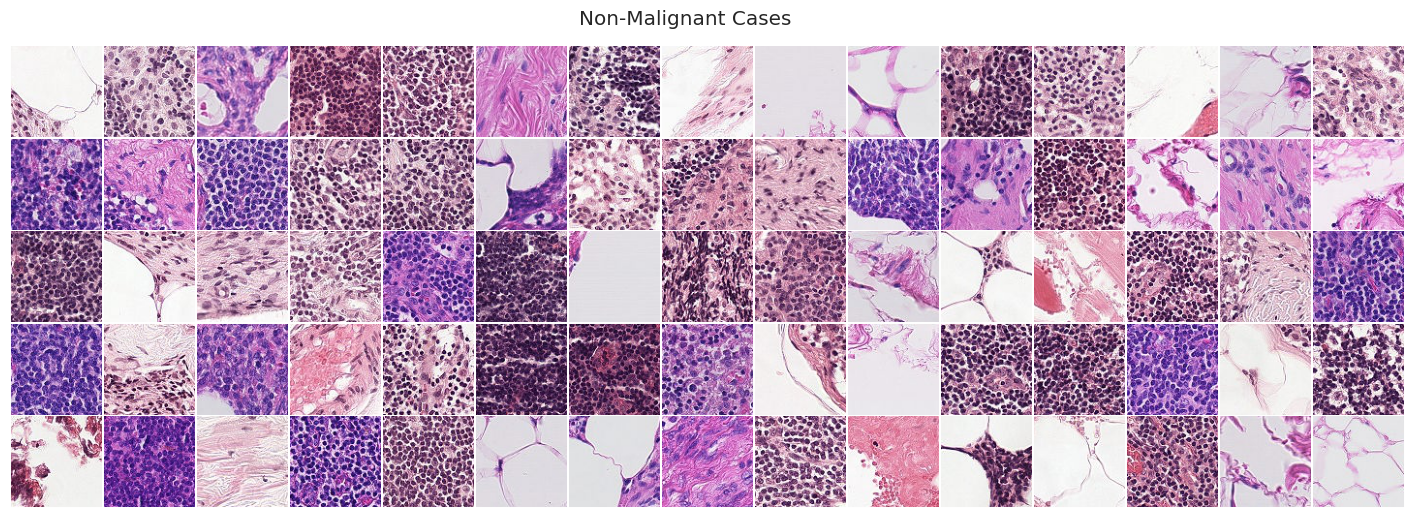

In [64]:
plot_img(normal,'Non-Malignant Cases')

.

> #  **Data Preprocessing**

In [16]:
torch.manual_seed(0) # fix random seed

class pytorch_data(Dataset):
    
    def __init__(self,data_dir,transform,data_type="train"):      
    
        cdm_data=os.path.join(data_dir,data_type) 
        
        file_names = os.listdir(cdm_data) 
        idx_choose = np.random.choice(np.arange(len(file_names)), 10000, replace=False).tolist()
        
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]   
        
        labels_dir=os.path.join(data_dir,"train_labels.csv") 
        labels_df=pd.read_csv(labels_dir)
        labels_df.set_index("id", inplace=True) 
        
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample]  
        self.transform = transform
      
    def __len__(self):
        return len(self.full_filenames) 
      
    def __getitem__(self, idx):
        
        image = Image.open(self.full_filenames[idx])  
        image = self.transform(image) 
        return image, self.labels[idx]


In [17]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),transforms.Resize((48,48))])

In [18]:
data_dir = '/content/'
img_dataset = pytorch_data(data_dir, data_transformer, "train")

In [20]:
img,label=img_dataset[10]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 48, 48]) tensor(0.0157) tensor(1.)


> ## Splitting in 80:20 (train:val) 

In [65]:
len_img=len(img_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train


train_ts,val_ts=random_split(img_dataset, [len_train,len_val])

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 8000
validation dataset size: 2000


In [24]:
import plotly.express as px

def plot_fig(x,y,title=None):

    npimg = x.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=500,margin={'l':10,'r':20,'b':10})
    fig.show()

> ## Plotting some training and Validation Dataset


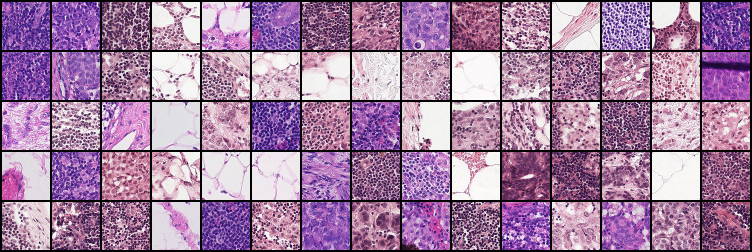

In [25]:
grid_size=75
rnd_inds=np.random.randint(0,len(train_ts),grid_size)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=15, padding=2)
    
plot_fig(x_grid_train,y_grid_train,'Training Subset Examples')


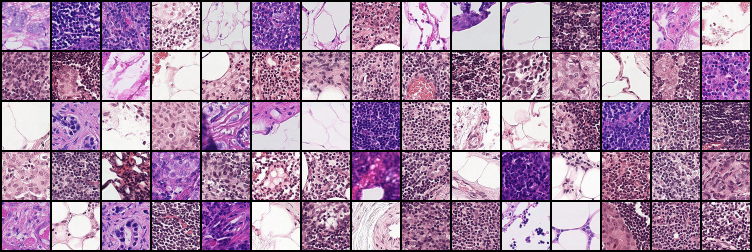

In [26]:
grid_size=75

rnd_inds=np.random.randint(0,len(val_ts),grid_size)
x_grid_val=[val_ts[i][0] for i in range(grid_size)]
y_grid_val=[val_ts[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=15, padding=2)

plot_fig(x_grid_val,y_grid_val,'Validation Dataset Preview')

> #  **Data Augmentation**

In [27]:
tr_transf = transforms.Compose([ transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5), 
                                    transforms.RandomRotation(45), transforms.ToTensor()])

In [28]:
val_transf = transforms.Compose([transforms.ToTensor()])


train_ts.transform=tr_transf
val_ts.transform=val_transf

In [29]:
train_ts.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

> ### **Making DataLoaders**

In [30]:
from torch.utils.data import DataLoader

# Training DataLoader
train_dl = DataLoader(train_ts,batch_size=64, shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,batch_size=64, shuffle=False)

.

> # **Making the Training Model**

In [31]:
def findConv2dOutShape(hin,win,conv,pool=2):
    
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [32]:
params_model={
        "shape_in": (3,48,48), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

cnn_model = Network(params_model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [33]:
loss_func = nn.NLLLoss(reduction="sum")

In [34]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [35]:

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) 
    pred = output.argmax(dim=1, keepdim=True) 
    metric_b=pred.eq(target.view_as(pred)).sum().item() 
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) 
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) 
        run_loss+=loss_b        

        if metric_b is not None: 
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  
    metric=t_metric/float(len_data) 
    
    return loss, metric

In [36]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 200,
 "optimiser": optim.Adam(cnn_model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
 "check": False, 
}


In [37]:
from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):
    
    
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} 
    metric_history={"train": [],"val": []} 
    best_model_wts = copy.deepcopy(model.state_dict()) 
    best_loss=float('inf') 
    
    for epoch in tqdm(range(epochs)):

        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

> # Training the model 

In [38]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 200,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}


cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/200 [00:00<?, ?it/s]

In [40]:
epochs=params_train["epochs"]

fig = make_subplots(rows=1, cols=2,subplot_titles=['lost_hist','metric_hist'])
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["train"],name='loss_hist["train"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["val"],name='loss_hist["val"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["train"],name='metric_hist["train"]'),row=1, col=2)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["val"],name='metric_hist["val"]'),row=1, col=2)
fig.update_layout(template='plotly_white');fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
fig.show()

In [41]:
class pytorchdata_test(Dataset):
    
    def __init__(self, data_dir, transform,data_type="train"):
        
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        labels_df.set_index("id", inplace=True)
        
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform       
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [42]:
# !ls
# !ls '/content/test' | head -n 5
# cnn_model.load_state_dict(torch.load('weights.pt'))

drive	     sample_submission.csv  train	      weights.pt
sample_data  test		    train_labels.csv
00006537328c33e284c973d7b39d340809f7271b.tif
0000ec92553fda4ce39889f9226ace43cae3364e.tif
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
000270442cc15af719583a8172c87cd2bd9c7746.tif


<All keys matched successfully>

In [43]:
data_dir = '/content/'

data_transformer = transforms.Compose([transforms.ToTensor(), transforms.Resize((46,46))])

img_dataset_test = pytorchdata_test(data_dir,data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')


57458 samples found


In [44]:
def inference(model,dataset,device,num_classes=2):
    
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) 
    y_gt=np.zeros((len_data),dtype="uint8") 
    model=model.to(device) 
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt            

In [45]:
y_test_out,_ = inference(cnn_model,img_dataset_test, device) 

y_test_pred=np.argmax(y_test_out,axis=1)

  0%|          | 0/57458 [00:00<?, ?it/s]

In [54]:
from google.colab import output


correct = 0

for i in range(len(y_test_pred)):
    if i%1000 == 0:
        output.clear()
        print("[{}/{}]".format(i+1, len(y_test_pred)))
    
    if img_dataset_test[i][1] == y_test_pred[i]:
        correct += 1    

[57001/57458]


In [61]:
print("Accuracy of the CNN model is : ", correct/len(y_test_pred)*100, "%")

Accuracy of the CNN model is :  75.77534895053778 %
